In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
train_fpath = '../../data/processed/IMDB_reviews_train_cleaned.json'
test_fpath = '../../data/processed/IMDB_reviews_test.json'

In [3]:
train = pd.read_json(train_fpath)
test = pd.read_json(test_fpath)

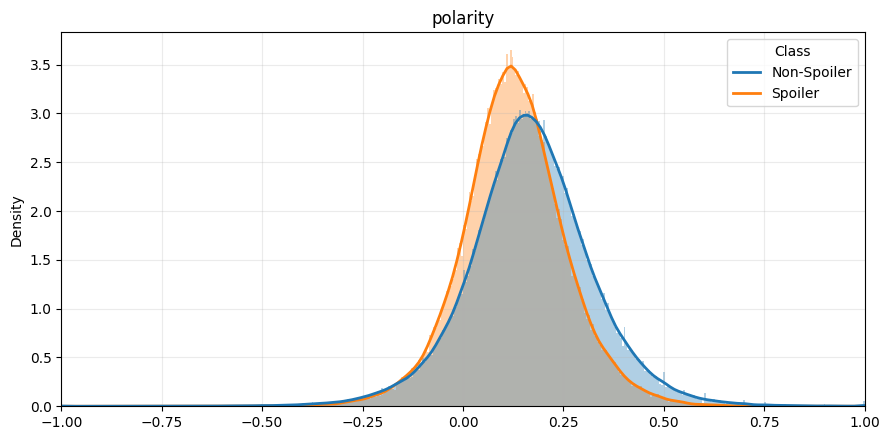

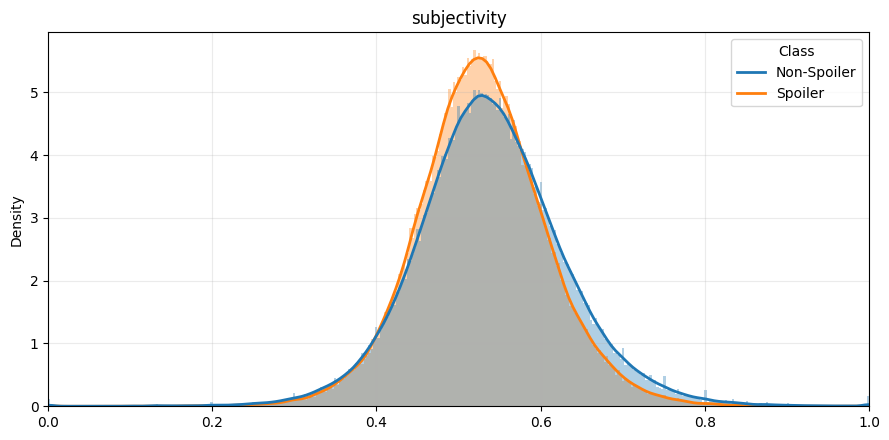

In [4]:
histo_features = [
    "polarity", "subjectivity"
]

for f in histo_features:
    x0 = train.loc[train["is_spoiler"] == 0, f].dropna()
    x1 = train.loc[train["is_spoiler"] == 1, f].dropna()
    allx = pd.concat([x0, x1], ignore_index=True)

    if f == "polarity":
        lo, hi = -1.0, 1.0
    elif f == "subjectivity":
        lo, hi = 0.0, 1.0
    else:
        lo, hi = np.nanpercentile(allx, [0.5, 99.5])
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            lo, hi = allx.min(), allx.max()

    x0 = x0.clip(lo, hi)
    x1 = x1.clip(lo, hi)
    both = pd.concat([x0, x1], ignore_index=True)
    bins = np.histogram_bin_edges(both, bins="auto")

    df_plot = pd.DataFrame({
        f: np.concatenate([x0.values, x1.values]),
        "Class": (["Non-Spoiler"] * len(x0)) + (["Spoiler"] * len(x1))
    })

    fig, ax = plt.subplots(figsize=(9, 4.5))

    sns.histplot(
        data=df_plot, x=f, hue="Class",
        bins=bins, stat="density", multiple="layer",
        common_bins=True, common_norm=False,
        alpha=0.35, edgecolor=None, ax=ax
    )


    sns.kdeplot(
        data=df_plot, x=f, hue="Class",
        common_norm=False, fill=False, lw=2, ax=ax
    )

    ax.set_xlim(lo, hi)
    ax.set_title(f"{f}")
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

In [5]:
train.head(5)

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,...,release_date,plot_synopsis,review_year,review_month,review_day,release_year,release_month,release_day,polarity,subjectivity
407943,1156377600000,tt0463985,ur10173727,False,i saw the i not impressed not a but the car ar...,5,not such a good movie,An American teenager named Sean Boswell is a l...,104,"[Action, Crime, Thriller]",...,1150416000000,"In rural Arizona, a young, 17-year-old, rednec...",2006,8,24,2006,6,16,0.446429,0.619444
171849,1430870400000,tt0790724,ur0453068,False,jack reacher solid action set piece when they ...,6,"good stuff, except...","In an innocent heartland city, five are shot d...",130,"[Action, Crime, Mystery]",...,1356048000000,"In Pittsburgh, Pennsylvania, a man drives a va...",2015,5,6,2012,12,21,0.195402,0.588697
557247,1132876800000,tt0160862,ur7395261,True,i saw not another teen watching although did n...,10,A good movie to pass the time,She's All That is your typical high school pro...,95,"[Comedy, Romance]",...,917568000000,None,2005,11,25,1999,1,29,0.106347,0.621815
374693,1147737600000,tt0388795,ur8323774,False,absolutely the best film should have done at t...,10,Heart Wrenching,"Two young men, Ennis Del Mar and Jack Twist, m...",134,"[Drama, Romance]",...,1137110400000,"In the summer of 1963, two young men meet when...",2006,5,16,2006,1,13,0.340985,0.621667
546384,1324771200000,tt0120812,ur24340247,True,rush hour starting jackie chan chris tucker th...,10,The Best Action Comedy Movie Ever,Cultures clash and tempers flares as the two c...,98,"[Action, Comedy, Crime]",...,906076800000,When kidnappers grab a Chinese official's daug...,2011,12,25,1998,9,18,0.265476,0.472619


In [6]:
def to_list_genre(x):
    s = str(x).strip().strip('[]')
    if not s: return []
    return [p.strip().strip("'\"") for p in s.split(',') if p.strip()]


In [7]:
g_lists = train['genre'].apply(to_list_genre)
mlb = MultiLabelBinarizer()
G = pd.DataFrame(
    mlb.fit_transform(g_lists),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=train.index
)
train = pd.concat([train, G], axis=1)

In [8]:
genre_cols = [c for c in train.columns if c.startswith("genre_")]

genre_counts = train[genre_cols].sum().sort_values(ascending=False)
genre_sorted = train[genre_cols].sum().sort_values(ascending=False).index.tolist()

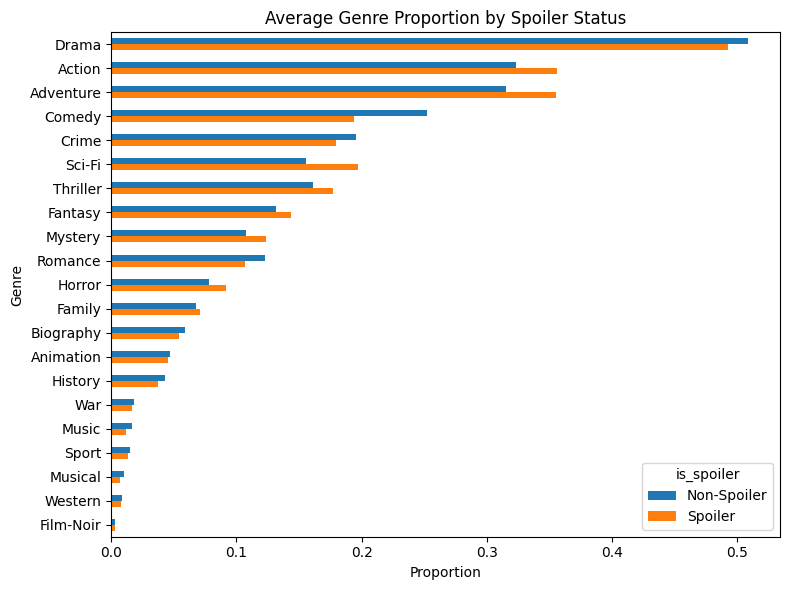

In [9]:
proportion = (
    train.groupby("is_spoiler")[genre_sorted].mean().T
      .rename(columns={0:"Non-Spoiler",1:"Spoiler",False:"Non-Spoiler",True:"Spoiler"})
)

proportion.index = (
    pd.Index(proportion.index)
      .str.replace(r"^genre_", "", regex=True)
      .str.replace("_", " ")
      .str.title()
)

order = proportion.mean(axis=1).sort_values(ascending=False).index
ax = proportion.loc[order].plot(kind="barh", figsize=(8,6))
ax.invert_yaxis()  # put largest at the top
ax.set_title("Average Genre Proportion by Spoiler Status")
ax.set_xlabel("Proportion")
ax.set_ylabel("Genre")
plt.tight_layout()
plt.show()

In [10]:
def parse_mixed_date(col: pd.Series) -> pd.Series:
    dt = pd.to_datetime(col, unit="ms", errors="coerce")
    need = dt.isna()
    if need.any():
        dt.loc[need] = pd.to_datetime(pd.to_numeric(col[need], errors="coerce"), unit="s", errors="coerce")
    need = dt.isna()
    if need.any():
        dt.loc[need] = pd.to_datetime(col[need], errors="coerce")
    return dt

# parse dates
train["release_dt"] = parse_mixed_date(train["release_date"])
train["review_dt"]  = parse_mixed_date(train["review_date"])

delta = train["review_dt"] - train["release_dt"]
train["days_to_review"] = delta.dt.days

/var/folders/qw/0q1k53t510l2k5m76b5xnqp40000gn/T/ipykernel_12387/415304206.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  days_rate = time_data.groupby(bins)["is_spoiler"].mean()


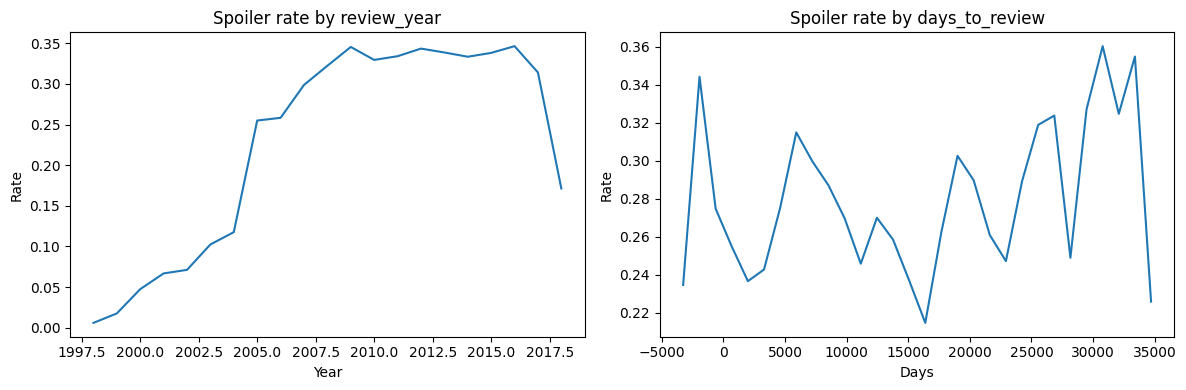

In [11]:
time_data = train.loc[train["is_spoiler"].notna(), ["review_year","days_to_review","is_spoiler"]].copy()

year_rate = time_data.groupby("review_year")["is_spoiler"].mean().dropna()

bins = pd.cut(time_data["days_to_review"], bins=30)
days_rate = time_data.groupby(bins)["is_spoiler"].mean()
x_mid = pd.Series([(b.left + b.right)/2 for b in days_rate.index], index=days_rate.index)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=year_rate.index, y=year_rate.values, ax=ax[0])
sns.lineplot(x=x_mid.values, y=days_rate.values, ax=ax[1])
ax[0].set_title("Spoiler rate by review_year"); ax[0].set_xlabel("Year"); ax[0].set_ylabel("Rate")
ax[1].set_title("Spoiler rate by days_to_review"); ax[1].set_xlabel("Days"); ax[1].set_ylabel("Rate")
plt.tight_layout(); plt.show()